
<h1><center><b>Project One</b></center></h1>

<h3><center><i>Jordan Sinclair</i></center></h3>

# <h1><center><b>Notebook Setup</b></center></h1>

When you are done with this notebook, run the following code cell to unmount Google Drive

In [ ]:
from google.colab import drive
drive.flush_and_unmount()
print('All changes made in this colab session should now be visible in Drive.')

All changes made in this colab session should now be visible in Drive.


The following code cell installs additional dependencies required to run the Jupyter Notebooks used in this class.



In [ ]:
# Add additional Python packages that we will be using in class
!apt install graphviz build-essential checkinstall imagemagick
# Base Python packages to run example Jupyter Notebooks
!pip install watermark pyprind mlxtend
# Python packages to visualize Decision Tree Classifiers
!pip install pydotplus graphviz pyparsing
# Python packages for Natrual Language Processing
!pip install nltk
# Python packages for Flask-based web applications
!pip install flask wtforms
# Python packages for TensorFlow
!pip install tensorflow tensorflow-datasets

Reading package lists... Done
Building dependency tree       
Reading state information... Done
build-essential is already the newest version (12.4ubuntu1).
checkinstall is already the newest version (1.6.2-4ubuntu2).
graphviz is already the newest version (2.40.1-2).
imagemagick is already the newest version (8:6.9.7.4+dfsg-16ubuntu6.11).
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


The following code cell defines a variable equal to the location inside your Google Drive where you copied the ch03 folder

In [ ]:
##### TODO CHANGE THIS TO THE PATH IN GOOGLE DRIVE WHERE YOU COPIED THE ch03 FOLDER #####
google_drive_root='/machine-learning/Project One Jordan Sinclair'

In [ ]:
google_drive_mount_location = '/content/drive'
google_file_prefix=google_drive_mount_location + '/My Drive/' + google_drive_root + '/'

The following code cell mounts your Google Drive into the runtime of the workbook, so that you can access files.

In [ ]:
# Read more here: https://colab.research.google.com/notebooks/io.ipynb#scrollTo=D78AM1fFt2ty
from google.colab import drive
drive.mount(google_drive_mount_location)

Mounted at /content/drive


# <h1><center><b>Experiment Objective</b></center></h1>

<body>
<center>

I chose to create my own dataset for this project by gathering accelerometer and gyroscope data from an MPU6050 sensor and an Arduino Uno. This dataset was categorized into four main classes:


<b>
Up

Down

Left

Right
</b>

It is intended to be used in the future as a part of another project I am working on: the Tactile Color Control (TCC). As the controller is moved up or down, it will increase or decrease the brush size in an art application, Procreate. Additionally, if it is rotated left or right, the controller will change the color along a colorwheel. 
The dataset includes 1000 samples; 250 of each of the four classes. There are several missing values, as shown below. 

The Arduino Terms of Service include the following paragraph describing it's use in creating projects:

In general, we're happy to see people talking about Arduino, writing tutorials about Arduino, discussing projects that use Arduino boards, using the Arduino software with their hardware, etc. The project depends on the creations of the community, and we want to encourage these activities.

Additionally, the following constraints are implemented: 


*   what you are referring to must, in fact, meet the guidelines described above,

*   you do not imply that your work is affiliated with or endorsed by the Arduino team if you haven't talked with us,

*   you do not include the word "Arduino" (or derivatives thereof) in the name of your product, company, or domain name without permission


Policy. Arduino. (n.d.). https://www.arduino.cc/en/main/policy
</center>
</body>


# <center><b>Imports</b></center>

In [ ]:
#Imports image so that any relevant pictures can be displayed. 
from IPython.display import Image

#Imports for data preprocessing:
import numpy as np
import pandas as pd
from io import StringIO
import sys
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

#For plotting:
%matplotlib inline
import matplotlib.pyplot as plt

#For machine learning models:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV

# <h1><center><b>Data Collection</b></center></h1>

I used an Arduino Uno, and Excel's Data Streamer to collect data from an MPU-6050 accelerometer and gyroscope sensor. The following code shows the Arduino sketch I used to run the accelerometer. 


```
#include <Wire.h>

const int MPU_ADDR = 0x68;

int16_t ax, ay, az;
int16_t gx, gy, gz;

char tmp_str[7];

char* convert_int16_to_str(int16_t i) {
  sprintf(tmp_str, "%6d", i);
  return tmp_str;
}

void setup() {
  Serial.begin(9600);
  Wire.begin();
  Wire.beginTransmission(MPU_ADDR);
  Wire.write(0x68);
  Wire.write(0);
  Wire.endTransmission(true);
}

void loop() {
  Wire.beginTransmission(MPU_ADDR);
  Wire.write(0x3B);
  Wire.endTransmission(false);
  Wire.requestFrom(MPU_ADDR, 6*2, true);
  
  ax = Wire.read() << 8 | Wire.read();
  ay = Wire.read() << 8 | Wire.read();
  az = Wire.read() << 8 | Wire.read();
  gx = Wire.read() << 8 | Wire.read();
  gy = Wire.read() << 8 | Wire.read();
  gz = Wire.read() << 8 | Wire.read();

  Serial.print(convert_int16_to_str(ax));
  Serial.print(", ");
  Serial.print(convert_int16_to_str(ay));
  Serial.print(", ");
  Serial.print(convert_int16_to_str(az));
  Serial.print(", ");
  Serial.print(convert_int16_to_str(gx));
  Serial.print(", ");
  Serial.print(convert_int16_to_str(gy));
  Serial.print(", ");
  Serial.print(convert_int16_to_str(gz));
  Serial.println();

  delay(150);
}
```

I referenced the following YouTube videos when writing the Arduino program and learning how to use Excel's Data Streamer to convert the Serial output from the Arduino to a csv format. 

Michael Schoeffler. (2017, October 14). <i>Tutorial: Gyroscope and Accelerometer GY-521/MPU6050) with Arduino</i>. [Video]. YouTube. https://youtu.be/wTfSfhjhAU0

Jen Foxbot. (2019, May 3). <i>How to Read Arduino into Excel!</i> [Video]. YouTube. https://youtu.be/DS09LYh6n4k

The following cell retreives the csv data file downloaded from Excel. 

In [ ]:
#Location of the dataset in Google Drive 
data = google_file_prefix + 'AccGyroData.csv'

#If using a version before 3.0, the dataset must be converted to unicode.
if (sys.version_info < (3, 0)):
    data = unicode(data)

#Reads the csv data into a Pandas DataFrame, df. 
df = pd.read_csv(data, header=None, encoding='utf-8')

#Shows the first five rows of the dataset. 
df.head()

,0,1,2,3,4,5,6
0,2368.0,-5292.0,16204.0,1408.0,699.0,1417.0,IN
1,2940.0,-4804.0,15836.0,1360.0,480.0,1582.0,IN
2,904.0,-4580.0,14472.0,1408.0,876.0,2274.0,IN
3,2436.0,-5412.0,17144.0,1360.0,-1909.0,967.0,IN
4,952.0,-5580.0,17124.0,1424.0,-1747.0,853.0,IN


# <center><b>Data Preprocessing</b></center>

I changed the names of the columns below because I thought it might make it easier to use while preprocessing rather than remembering which number went to each feature column. 

In [ ]:
#Sets the column names. 
df.columns = ["AccX", "AccY", "AccZ", "GyroX", "GyroY", "GyroZ", "class_label"]
df.head()

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,class_label
0,2368.0,-5292.0,16204.0,1408.0,699.0,1417.0,IN
1,2940.0,-4804.0,15836.0,1360.0,480.0,1582.0,IN
2,904.0,-4580.0,14472.0,1408.0,876.0,2274.0,IN
3,2436.0,-5412.0,17144.0,1360.0,-1909.0,967.0,IN
4,952.0,-5580.0,17124.0,1424.0,-1747.0,853.0,IN


Since the class labels are currently categorical rather than numerical, it is necessary to create a class mapping that essentially maps each unique label to an integer counterpart so that they are identifiabile by the machine learning algorithms. 

In [ ]:
#Creates a class mapping so that each categorical label is mapped to an integer. 
class_mapping = {label: idx for idx, label in enumerate(np.unique(df['class_label']))}
class_mapping

{'IN': 0, 'LEFT': 1, 'OUT': 2, 'RIGHT': 3}

In [ ]:
#Converts the current class labels
df['class_label'] = df['class_label'].map(class_mapping)

Now the class labels are represented as integers between 0 and 3, as shown below. 

In [ ]:
df

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,class_label
0,2368.0,-5292.0,16204.0,1408.0,699.0,1417.0,0
1,2940.0,-4804.0,15836.0,1360.0,480.0,1582.0,0
2,904.0,-4580.0,14472.0,1408.0,876.0,2274.0,0
3,2436.0,-5412.0,17144.0,1360.0,-1909.0,967.0,0
4,952.0,-5580.0,17124.0,1424.0,-1747.0,853.0,0
...,...,...,...,...,...,...,...
995,1376.0,1260.0,17176.0,1664.0,-33.0,282.0,3
996,1368.0,1268.0,17128.0,1728.0,-54.0,306.0,3
997,1404.0,1224.0,17192.0,1728.0,-37.0,288.0,3
998,1396.0,1208.0,17160.0,1664.0,-47.0,296.0,3


This cell indicates how many missing values are present in each column of the dataset. There are several rows without data in certain columns. 

In [ ]:
df.isnull().sum()

AccX           5
AccY           7
AccZ           3
GyroX          3
GyroY          2
GyroZ          3
class_label    0
dtype: int64

It is necessary to either impute or drop the missing values in the dataset so that various learning models can be implemented. 

The following line drops any of the rows that contain less than four real values. 

In [ ]:
#Drops any missing values with under four real values. 
df = df.dropna(axis=0, thresh=4)
df.shape

(999, 7)

Since the length of the dataset is now 999, one row had over three missing values. Now the total amount of null values for the data is:

In [ ]:
df.isnull().sum()

AccX           4
AccY           6
AccZ           2
GyroX          3
GyroY          1
GyroZ          3
class_label    0
dtype: int64

I don't want to remove too many rows from the dataset, so I am going to impute the rest of the missing values. The following piece of the data frame indicates one section that contains a few missing values so that I can compare it before and after imputing. 

In [ ]:
#Displays a section of the dataframe that contains missing values. 
df.iloc[[764, 765, 766, 767, 768, 769, 770]]

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,class_label
765,408.0,1824.0,17132.0,1552.0,-134.0,264.0,3
766,NaN,1280.0,17200.0,1504.0,-53.0,273.0,3
767,692.0,NaN,17308.0,1488.0,-79.0,298.0,3
768,656.0,1244.0,17112.0,1504.0,-38.0,298.0,3
769,820.0,1256.0,17152.0,1536.0,-9.0,354.0,3
770,848.0,1296.0,17180.0,1584.0,-60.0,323.0,3
771,180.0,1192.0,16996.0,1504.0,-14.0,47.0,3


After the following code block runs, those missing values will be imputed. I chose to use Pandas' 'fillna' function in order to impute the null values with a forward fill algorithm. This method will propogate the value present in the last row into the one that is missing. The reason I chose to use a forward fill rather than something like the column average is because of the nature of the data I collected. Each class label has very different feature values and taking the mean of the whole column to fill a missing value would throw the data off by putting, for example, a large number into an area with smaller values. Thus, I decided that carrying the same value from the previous row would be a reasonable approach. 

In [ ]:
#Fills the missing values with the same value from the row before. 
#(Forward Fill)
df = df.fillna(method='ffill', axis=0) 
#Shows the same section of the dataset.  
df.iloc[[764,765, 766, 767, 768, 769, 770]]

,AccX,AccY,AccZ,GyroX,GyroY,GyroZ,class_label
765,408.0,1824.0,17132.0,1552.0,-134.0,264.0,3
766,408.0,1280.0,17200.0,1504.0,-53.0,273.0,3
767,692.0,1280.0,17308.0,1488.0,-79.0,298.0,3
768,656.0,1244.0,17112.0,1504.0,-38.0,298.0,3
769,820.0,1256.0,17152.0,1536.0,-9.0,354.0,3
770,848.0,1296.0,17180.0,1584.0,-60.0,323.0,3
771,180.0,1192.0,16996.0,1504.0,-14.0,47.0,3


All of the missing values have now been accounted for, as indicated by the following summary. 

In [ ]:
df.isnull().sum()

AccX           0
AccY           0
AccZ           0
GyroX          0
GyroY          0
GyroZ          0
class_label    0
dtype: int64

Since my preprocessing procedure included removing samples with missing features, it is necessary to verify that each of the classes are still reasonably balanced. Although the third class does have one less example than the rest, I don't think that it will cause a major problem for the model.

In [ ]:
df['class_label'].value_counts() #Counts the number of examples for each class. 

3    250
1    250
0    250
2    249
Name: class_label, dtype: int64

I decided to split the data with a 35% test size. I have a smaller dataset and I wanted to ensure that the test set was large enough to maintain a similar accuracy to the training set. Since I have 999 data samples, a 35% split gave about 350 samples to the test set. To show this, I printed the ratio of the training to testing data below. 

In [ ]:
#Gets the x (features) and y (class labels) data from the dataframe. 
X, y = df.iloc[:, 0:6].values, df.iloc[:, 6].values 
#Designates the training and testing data using the train_test_split function. 
#Uses a test size of 35% as described above. 
X_train, X_test, y_train, y_test =\
    train_test_split(X, y, 
                     test_size=0.35, 
                     random_state=0, 
                     stratify=y)
#Prints the ratio of training to testing data. 
print("Training/testing: ", len(X_train), "/", len(X_test))

Training/testing:  649 / 350


The data must be scaled because the accelerometer and gyroscope gave very highly distributed values. If each variable is on the same scale, the model can be more effectively trained. I decided to use the StandardScaler implementation over the MinMaxScaler because my data seems to have several outliers and varying values due to my taking it in maybe not the most accurate way and because of the sensor's capabilities.

In [ ]:
from sklearn.preprocessing import StandardScaler

stdsc = StandardScaler() #Creates the standard scaler object
#Standardizes the training and test data. 
X_train_std = stdsc.fit_transform(X_train)
X_test_std = stdsc.transform(X_test)
#Prints the results of the transformation. 
print("Standardized data:\n")
print("Test -> \n", X_test_std)
print("\n")
print("Train -> \n", X_train_std)

Standardized data:

Test -> 
 [[-0.24241105  0.74859032  0.350388    0.55730845 -0.02706591  0.03783146]
 [ 0.00864622  0.74624893  0.42108752 -1.57029852 -0.03140509  0.05133604]
 [ 0.75113473 -2.2179449  -2.24942636 -0.27009426  0.80132232  0.57544244]
 ...
 [ 0.68703501 -2.65695465 -4.99385339 -0.62469542 -1.74222401 -0.15959267]
 [-0.57893462  0.72283508  0.36002884 -0.74289581 -0.02706591  0.00567769]
 [-0.54421393  0.76849209  0.37609691  1.38471117 -0.01759862  0.02304073]]


Train -> 
 [[ 0.00330458  0.74039547  0.36645607 -1.33389775 -0.02233226  0.01918227]
 [ 0.08877088 -0.19850005  0.25719317  0.0845069  -0.48938543 -0.17052495]
 [ 0.42529445  0.66664183  0.51428235  0.91190962  0.05892868  0.11435742]
 ...
 [-1.04098682  0.68420222  0.29897016  0.0845069  -0.0191765   0.06098217]
 [ 0.14218732 -1.48509129 -0.8450767   0.0845069  -0.0527065  -0.2213279 ]
 [ 0.07274595 -2.96367613 -2.75075027  0.20270729  2.03562078 -0.81167107]]


The data above indicates the new testing and training data standardized to a range that is centered around 0. This is beneficial for implementing algorithms such as the SVM classifier where the weights are initialized at or around 0. 

Now, the most meaningful features can be determined using a random forest and the SelectFromModel object, which will select the most appropriate features given a designated threshold value.

 1) GyroX                          0.381541
 2) AccX                           0.174471
 3) AccY                           0.173594
 4) GyroY                          0.103889
 5) AccZ                           0.086193
 6) GyroZ                          0.080311


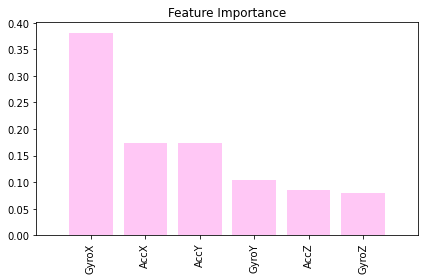

In [ ]:
#Sets the column labels
feat_labels = df.columns[0:6]

#Creates a Random Forest Classifier with 500 estimators. 
forest = RandomForestClassifier(n_estimators=500,
                                random_state=1)

#Fits the forest to the training data. 
forest.fit(X_train_std, y_train)
#Sets the importances of the features. 
importances = forest.feature_importances_

#Sets the indices relative to the importances. 
indices = np.argsort(importances)[::-1]

for f in range(X_train.shape[1]):
  #Prints the importances and labels (in order of importance)
    print("%2d) %-*s %f" % (f + 1, 30, 
                            feat_labels[indices[f]], 
                            importances[indices[f]]))
#Creates a bar chart depicting this data. 
plt.title('Feature Importance')
plt.bar(range(X_train.shape[1]), 
        importances[indices],
        align='center',
        color="#ffc7f5")

plt.xticks(range(X_train.shape[1]), 
           feat_labels[indices], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.tight_layout()
plt.show()

Evidently, the most important feature is the x coordinate for the gyroscope sensor. This makes sense because I am primarily trying to track rotational motion. Additionally, the accelerometer x and y components are the next most important; which also makes sense as they correspond to the linear motion of the sensor while rotating. Finally, both the Z coordinates for the accelerometer and gyroscope are the least important feature. This is reasonable because the four classes I decided to measure were not along the z axis. 

The following graph shows the changes of the gyroscope along the x axis. 

<function matplotlib.pyplot.show>

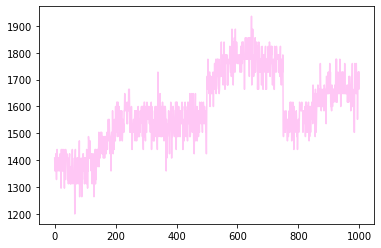

In [ ]:
plt.plot(df['GyroX'], '#ffc7f5')
plt.show

I can kind of make out the four different directions (up, down, right, and left) in the plot as it seems to have four distinct regions separated around each interval of 250. This further verifies the importance of the gyroscope's x measurements because it is highly correlated with the actual motion of the sensor. 

Additionally, the following plot compares the gyroscope values in the x direction with the respective class labels. It seems like there is a clear difference between each category, as expected. 

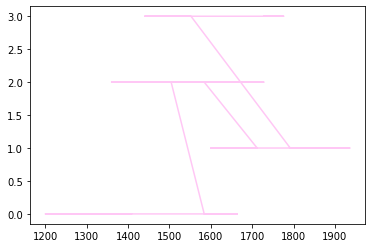

In [ ]:
plt.plot(df['GyroX'], df['class_label'], '#ffc7f5')

On the other hand, this plot shows the gyroscope values in the z direction, the lowest ranked feature. 

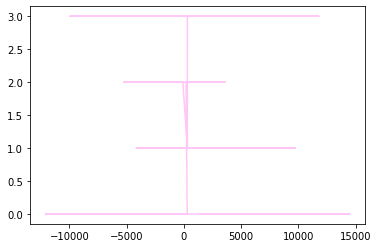

In [ ]:
plt.plot(df['GyroZ'], df['class_label'], '#ffc7f5')

There is very little difference between the classes, which would make it hard for the machine learning model to make accurate decisions. 

The following code uses the SelectFromModel feature selection technique to establish which features meet a threshold requirement of 0.12. 

In [ ]:
from sklearn.feature_selection import SelectFromModel

#Creates the select from model object using the forest from above and 
#the desired threshold. 
sfm = SelectFromModel(forest, threshold=0.12, prefit=True)
#Gets the desired feature columns from the standardized data. 
X_selected_train = sfm.transform(X_train_std)
X_selected_test = sfm.transform(X_test_std)
#Creates dataframes from the selected train and test data.
A = pd.DataFrame(X_selected_train)
B = pd.DataFrame(X_selected_test)
#Sets the column names of these dataframes for viewability. 
A.columns = ["GyroX", "AccX", "AccY"]
B.columns = A.columns
#Prints the number of features that meet the threshold for the training and 
#testing data. 
print('Number of training features that meet this threshold criterion:', 
      X_selected_train.shape[1])
print('Number of test features that meet the threshold criteria: ',
      X_selected_test.shape[1])


Number of training features that meet this threshold criterion: 3
Number of test features that meet the threshold criteria:  3


There are only three features (shown below) that meet a threshold criteria of 0.12. 

In [ ]:
A

,GyroX,AccX,AccY
0,0.003305,0.740395,-1.333898
1,0.088771,-0.198500,0.084507
2,0.425294,0.666642,0.911910
3,-1.278690,0.274460,1.384711
4,0.118150,0.796589,1.739312
...,...,...,...
644,1.987725,-0.655070,-0.270094
645,1.613810,-0.479466,-0.388295
646,-1.040987,0.684202,0.084507
647,0.142187,-1.485091,0.084507


# <h1><center><b>Model Comparison</b></center></h1>

In this section, three different machine learning models will be compared using the accuracy of each on both the testing and training data. I used a grid search for each to establish what the best conditions for each model would be in order to optimize my results when qualifying each model's accuracy. 

First, I decided to see how accurate a Random Forest Classifier would perform. I used a grid search with a varying number of estimators, either a bootstrap or not, and three different options for the random state, in order to determine the best combination for my data. 

In [ ]:
#Random Forest:

classifier = RandomForestClassifier(n_estimators=300, random_state=0)
grid_param = {
    'n_estimators': [100, 200, 500, 900],
    'criterion': ['gini'],
    'bootstrap': [True, False],
    'random_state': [0, 1, 3]
}
gs = GridSearchCV(estimator=classifier,
                  param_grid=grid_param,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)
gs.fit(A, y_train)
best_parameters = gs.best_params_
print(best_parameters)
#classifier.get_params().keys()

{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 200, 'random_state': 3}


It turned out that having 200 estimators, a random state of 3, and a bootstrap was the best. 

The following code scores the above grid search, random forest, model. It acheived a reasonable score of about 84% accuracy. 

In [ ]:
best_result = gs.best_score_
print(best_result)

0.844412641621944


Next, I wanted to examine a K Nearest Neighbors classifier. Again, I performed a grid search with varying options for the number of neighbors and p, and three options for the algorithm.

In [ ]:
knn = KNeighborsClassifier(n_neighbors=5, 
                           p=2, 
                           metric='minkowski')


In [ ]:
grid_param2 = {
    'n_neighbors': [3, 5, 10, 20],
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'metric': ['minkowski'],
    'p': [0, 2, 6]
}
gs2 = GridSearchCV(estimator=knn,
                  param_grid=grid_param2,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)
gs2.fit(A, y_train)
best_parameters2 = gs2.best_params_
print(best_parameters2)


{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 10, 'p': 6}


As the above results indicate, the best options included the 10 nearest neighbors, a p value of 6, and a ball tree algorithm. 

Now, the KNN algorithm could be scored using the grid search 'best_score' metric. It received a score of about 84.6%, which is very similar, but a little better, than the Random Forest implementation. 

In [ ]:
best_result2 = gs2.best_score_
print(best_result2)

0.8459511031604056


Finally, I wanted to test an SVC classifier. I hypothesized that it might be the best of the three because it has a lower generalization error and is less apt towards overfitting. Since my data was fairly highly distributed and not super exact, it seemed likely that overfitting may occur in some cases. I attempted to find the best model using a grid search again with several C values, different gamma and kernal options, and various random state values.

In [ ]:
svm = SVC(kernel='rbf', random_state=1, gamma=0.10, C=10.0)

In [ ]:
grid_param3 = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'computed'],
    'gamma': ['scale', 'auto', 0.1, 0.5],
    'C': [1, 5, 10, 15],
    'random_state': [0, 1, 2, 3]
}
gs3 = GridSearchCV(estimator=svm,
                  param_grid=grid_param3,
                  scoring='accuracy',
                  cv=5,
                  n_jobs=-1)
gs3.fit(A, y_train)
best_parameters3 = gs3.best_params_
print(best_parameters3)


{'C': 5, 'gamma': 0.5, 'kernel': 'rbf', 'random_state': 0}


This grid search resulted in an optimized Support Vector Machine model with a C value of 5, a gamma of 0.5, an rbf kernel, and a random state of 0. This model did actually perform the best, as I hypothesized, with about 86% accuracy. 

In [ ]:
best_result3 = gs3.best_score_
print(best_result3)

0.8567084078711986


The following function was used to verify the results above and print the best performing model. 

In [ ]:
def compare_models(x, y, z):
  s = ""
  if x > y and x > z:
    s = "Model One is the best!"
  elif y > x and y > z:
    s = "Model Two is the best!"
  elif z > x and z > y:
    s = "Model Three is the best!"
  print(s)
  return s

In [ ]:
best = compare_models(best_result, best_result2, best_result3)

Model Three is the best!


Now, each model must be implemented on the unseen testing data to measure accuracy. The following code determines the best parameters for each model using the same grid search options as above. 

In [ ]:
gs.fit(B, y_test)
best_parameters = gs.best_params_
print(best_parameters)

gs2.fit(B, y_test)
best_parameters2 = gs2.best_params_
print(best_parameters2)

gs3.fit(B, y_test)
best_parameters3 = gs3.best_params_
print(best_parameters3)


{'bootstrap': True, 'criterion': 'gini', 'n_estimators': 100, 'random_state': 0}
{'algorithm': 'ball_tree', 'metric': 'minkowski', 'n_neighbors': 3, 'p': 2}
{'C': 1, 'gamma': 0.5, 'kernel': 'rbf', 'random_state': 0}


The Random Forest Classifier's optimized parameters included a random state of 0, 100 estimators, and a true bootstrap. Additionally, the K Nearest Neighbors method was optimized when using a ball tree algorithm, 3 nearest neighbors, and a p value of 2. Finally, the Support Vector Machine algorithm was best when implementing a random state of 0, a C value of 1, a gamma value of 0.5, and an rbf kernel. 

The following block scores each of the optimized algorithms described above. The ranking was similar, where the SVM model was the best for the data, followed by the K Nearest Neighbors, and, in last place, the Random Forest Classifier. 

In [ ]:
best_result = gs.best_score_
print(best_result)

best_result2 = gs2.best_score_
print(best_result2)

best_result3 = gs3.best_score_
print(best_result3)

0.7942857142857143
0.8085714285714287
0.8171428571428571


In [ ]:
best_test = compare_models(best_result, best_result2, best_result3)

Model Three is the best!


All three models performed slightly worse on the testing data than the training data, where each landed at about 80% rather than 85%.  

# <center><b>Experiment Summary</b></center>

I started this experiment by creating my own dataset using an Arduino Uno and MPU-6050 accelerometer and gyroscope. I had a lot of fun learning how to gather data from Arduino into Excel and am really excited to come up with more machine learning implementations with Arduino and other microcontrollers. After collecting the data, I went on to preprocess it using various techniques. I started by resolving the missing values in the dataset by removing those containing fewer than three real values and using pandas 'fillna' method with a forward fill to impute the rest. This resulted in a fairly well balanced dataset. I then went on to map the categorical class labels to integer values. Next, I split the data into training and test sets, where the test set contained 35% of the original. I then standardized the test and training datasets using the Standard Scaler. Finally, the best features were chosen using a Random Forest and Select From Model method. The most meaningful features turned out to be the x coordinate of the gyroscope, and the x and y coordinates of the accelerometer. This lineup was consistant with the physical positions I chose.

I decided to compare the Random Forest, K Nearest Neighbors, and Support Vector Machine models. I thought that the SVM algorithm would perform the best of the three, which turned out to be true for both the testing and training data. I was also, however, hopnig that that the accuracy of each model would be a bit higher. The accuracies of the algorithms with the training data were centered around 85% and those for the test set were closer to 80%. While these are acceptable results, I was hoping to see outcomes closer to 90% or 95%. The SVM model performed the best at about 86% accuracy for the training dataset and around 82% for the test set. 

I learned a lot throughout this process. I feel like I gained a much deeper understanding of how the different techniques and algorithms we have covered so far work together to train and implement applicable models. I also learned more about the ethics of machine learning. Even though I didn't collect data from outside sources, I did use a microcontroller. To be honest, I hadn't given much thought to the fact that Arduino might have its own Terms of Service (TOS) before starting this project. I am glad that I was able to establish the best, and most ethical, means to collect my data. I plan to further my ideas using and to continue working with other microcontrollers in the future and I think that it is incredibly important to consider the ethical implications as well as the regulations in place when doing so. I really enjoyed working on this project. It was really exciting to dive into collecting data with sensors and to implement machine learning for my own application! I plan to eventually use what I have learned through this project in order to actually implement my Tacticle Color Controller. 